# Formula 1 driver performance comparison

At every race, drivers have to complete a qualifying lap on Saturday and race on the next day. Qualifying result will determine the position of the grid for the race. This analysis will serve the function to observe the relationship between the two-day results.

This analysis will use Formula 1 API from [Ergast](https://ergast.com/mrd/)

In [3]:
import requests as re
import pandas as pd
import json
from pandas import json_normalize
import seaborn as sns

In [13]:
main_df = pd.DataFrame()
data = []

for i in range(1,21):
    url = "https://ergast.com/api/f1/2021/qualifying/" + str(i) + ".json"
    response = re.get(url)
    json = response.json()
    df = json_normalize(json['MRData']['RaceTable']['Races'])
    drivers = []
    for j in json['MRData']['RaceTable']['Races']:
        for k in j['QualifyingResults']:
            drivers.append(k['Driver']['code'])
    df['QualifyingResults'] = drivers
    df['position'] = i
    data.append(df)

main_df = main_df.append(data, True)

In [18]:
main_df = main_df[['round', 'raceName', 'QualifyingResults', 'position']]
main_df.head()

,round,raceName,QualifyingResults,position
0,1,Bahrain Grand Prix,VER,1
1,2,Emilia Romagna Grand Prix,HAM,1
2,3,Portuguese Grand Prix,BOT,1
3,4,Spanish Grand Prix,HAM,1
4,5,Monaco Grand Prix,LEC,1


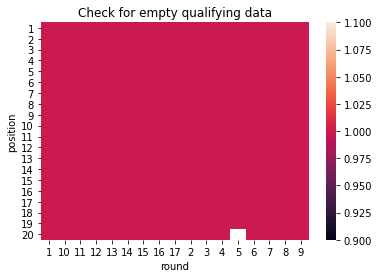

In [38]:
pivot = pd.pivot_table(main_df, values='QualifyingResults', index=['position'], columns=['round'], aggfunc='count')
ax = sns.heatmap(pivot)
ax.set_title('Check for empty qualifying data');

## Get race positions
[to do]

In [7]:
race_df = pd.DataFrame()
data = []

for i in range(1,21):
    url = "http://ergast.com/api/f1/2021/results/" + str(i) + ".json"
    response = re.get(url)
    json = response.json()
    df = json_normalize(json['MRData']['RaceTable']['Races'])
    drivers = []
    for j in json['MRData']['RaceTable']['Races']:
        for k in j['Results']:
            drivers.append(k['Driver']['code'])
    df['Results'] = drivers
    df['position'] = i
    data.append(df)

race_df = race_df.append(data, True)

In [9]:
race_df = race_df[['round', 'raceName', 'Results', 'position']]
race_df.head()

,round,raceName,Results,position
0,1,Bahrain Grand Prix,HAM,1
1,2,Emilia Romagna Grand Prix,VER,1
2,3,Portuguese Grand Prix,HAM,1
3,4,Spanish Grand Prix,HAM,1
4,5,Monaco Grand Prix,VER,1


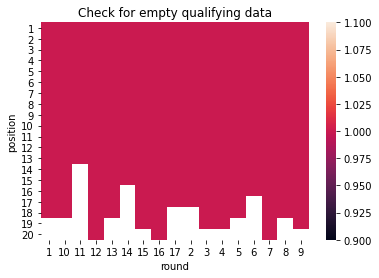

In [10]:
pivot = pd.pivot_table(race_df, values='Results', index=['position'], columns=['round'], aggfunc='count')
ax = sns.heatmap(pivot)
ax.set_title('Check for empty qualifying data');

## Merge the two tables
[to do]

## Export to csv or chart scatter plot of all data
[to do]